In [16]:
import os, gc
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='0'

import numpy as np 
import pandas as pd 

from sklearn.decomposition import TruncatedSVD

from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dropout, Dense, Embedding, concatenate, Flatten
from keras.regularizers import l2

import matplotlib.pyplot as plt

# timer function
import time
from contextlib import contextmanager
@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
start_time = time.time()

In [2]:
# standard directories
data_dir   = '../input/kaggle_data'
feat_dir   = '../input/features'
subm_dir   = '../submit'
weight_dir = '../input/model_weight'
model_name = 'model_ee_price'

In [3]:
num_cols = []
cat_cols = []

with timer("load data:"):
    usecols = ['item_id']
    train = pd.read_csv(f'{data_dir}/train.csv', index_col="item_id", usecols=usecols)
    test = pd.read_csv(f'{data_dir}/test.csv', index_col="item_id", usecols=usecols)

    train_split = len(train)
    
    gc.collect()

with timer("Loading Label Encoded Features:"):
    train_le = pd.read_csv(f'{feat_dir}/train_le.csv', index_col="item_id")
    test_le = pd.read_csv(f'{feat_dir}/test_le.csv', index_col="item_id")
    
    train = train.merge(train_le, how='left', left_index=True, right_index=True)
    test = test.merge(test_le, how='left', left_index=True, right_index=True)
    
    cat_cols += ['region','city','parent_category_name','category_name','user_type','param_1','param_2','param_3']
    
    del train_le, test_le
    gc.collect()
    
with timer("Loading Numeric Encoded Features:"):
    train_numeric = pd.read_csv(f'{feat_dir}/train_numeric.csv', index_col="item_id", usecols=['item_id', 'price', 'price_missing'])
    test_numeric = pd.read_csv(f'{feat_dir}/test_numeric.csv', index_col="item_id",  usecols=['item_id', 'price', 'price_missing'])
    
    train = train.merge(train_numeric, how='left', left_index=True, right_index=True)
    test = test.merge(test_numeric, how='left', left_index=True, right_index=True)

    cat_cols += ['price_missing']
                 
    del train_numeric, test_numeric
    gc.collect()
    
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)


[load data:] done in 5 s
[Loading Label Encoded Features:] done in 3 s
[Loading Numeric Encoded Features:] done in 3 s


In [4]:
# get target
y_train, y_valid = train['price'].values, test['price'].values
train.drop("price",axis=1, inplace=True)
test.drop("price",axis=1, inplace=True)

# convert to a dictionary
train['dataset'] = 'train'
test['dataset'] = 'test'
full = pd.concat([train, test]).reset_index(drop=True)

cat_cols = np.setdiff1d(full.columns, ['dataset', 'price'])
train = {c: train[c].values for c in cat_cols}
test = {c: test[c].values for c in cat_cols}

In [5]:
# categorical cardinality# categ 
input_size = {c: int(full[c].max()+1) for c in cat_cols}

# hardcode embedding size
output_size = {
    'parent_category_name': 3,
    'category_name': 5,
    'image_top_1': 15,
    'user_type': 3,
    'param_1': 25,
    'param_2': 25,
    'param_3': 25,
    'region': 3,
    'city': 5,
    'price_missing': 2,
}

In [6]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred))) 

def get_input_emb(emb_name):
    inp = Input(shape=[1], name=emb_name)  
    emb = Embedding(
        input_dim = input_size[emb_name],
        output_dim = output_size[emb_name])(inp)
    return inp, emb

def get_model():
    K.clear_session()
    input_list, emb_list = zip(*[get_input_emb(c) for c in cat_cols])
    x = concatenate([Flatten()(emb) for emb in emb_list])
    x = Dropout(0.1)(Dense(128, activation='elu')(x))
    x = Dropout(0.1)(Dense(64, activation='elu')(x))
    output = Dense(1, activation='elu') (x)
    model = Model(input_list, output)  
    model.compile(optimizer='adam', loss=root_mean_squared_error)
    return model

get_model().summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
category_name (InputLayer)      (None, 1)            0                                            
__________________________________________________________________________________________________
city (InputLayer)               (None, 1)            0                                            
__________________________________________________________________________________________________
param_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
param_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
param_3 (I

In [7]:
EARLY_STOPPING_ROUNDS = 3
WEIGHT_FILE = f'{weight_dir}/price_cat_emb.h5'

i = 0
count = 0
best_error = np.Inf
model = get_model()
while count<3:      
    
    # fit and validate
    history = model.fit(x=train, y=y_train,
                        validation_data=(test, y_valid),
                        batch_size=int(2**(10 + 0.5*i)))
    valid_error = history.history['val_loss'][0]

    # update early stopping
    if (valid_error < best_error):
        model.save_weights(WEIGHT_FILE)
        best_error = valid_error
        count = 0
    else:
        count += 1    
    i += 1
    
# reset best weights
model.load_weights(WEIGHT_FILE)

Train on 1503424 samples, validate on 508438 samples
Epoch 1/1
1503424/1503424 [==============================] - 11s 7us/step - loss: 0.0636 - val_loss: 0.0328
Train on 1503424 samples, validate on 508438 samples
Epoch 1/1
1503424/1503424 [==============================] - 7s 5us/step - loss: 0.0709 - val_loss: 0.0347
Train on 1503424 samples, validate on 508438 samples
Epoch 1/1
1503424/1503424 [==============================] - 5s 4us/step - loss: 0.0808 - val_loss: 0.0374
Train on 1503424 samples, validate on 508438 samples
Epoch 1/1
1503424/1503424 [==============================] - 4s 3us/step - loss: 0.0914 - val_loss: 0.0395


In [8]:
# extract weights# extra 
full_weights = []
for i,c in enumerate(cat_cols):
    w = model.get_layer(f'embedding_{i+1}').get_weights()[0]
    full_weights.append(w[full[c], :])
    
full_weights = np.concatenate(full_weights, 1)    
full_weights = full_weights - np.mean(full_weights, 0) # center
full_weights = full_weights/np.std(full_weights, 0)    # scale

In [9]:
# reduce by svd
tsvd = TruncatedSVD(20, n_iter=25)
full_svd = tsvd.fit_transform(full_weights)

# split data train_split
train_svd = full_svd[full['dataset']=='train', :]
test_svd = full_svd[full['dataset']=='test', :]

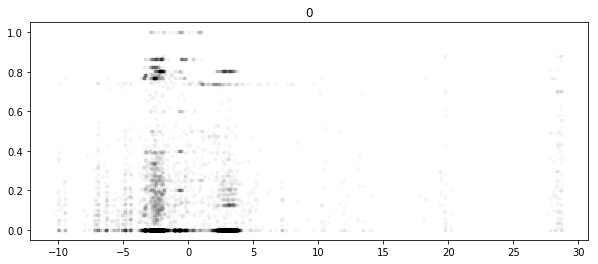

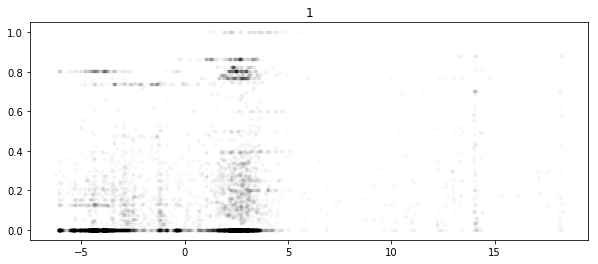

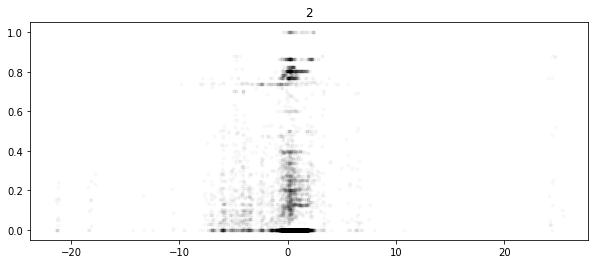

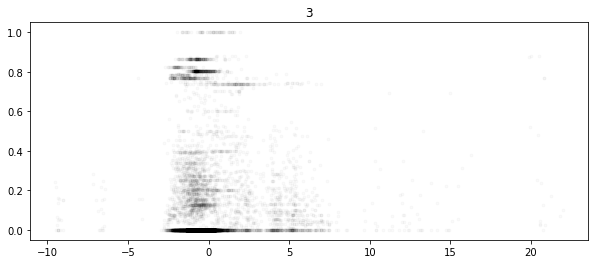

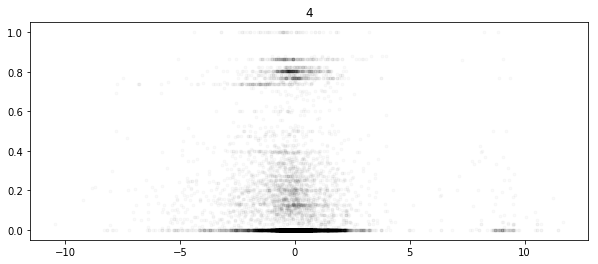

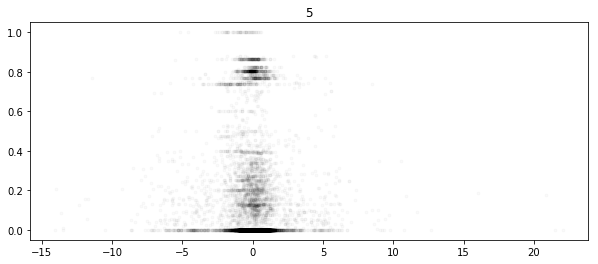

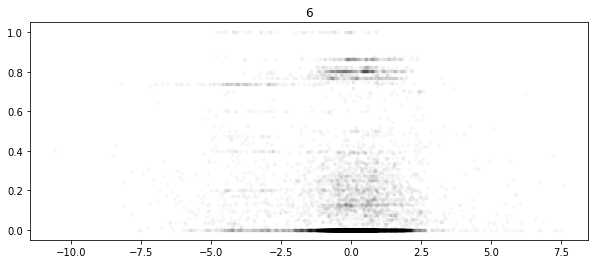

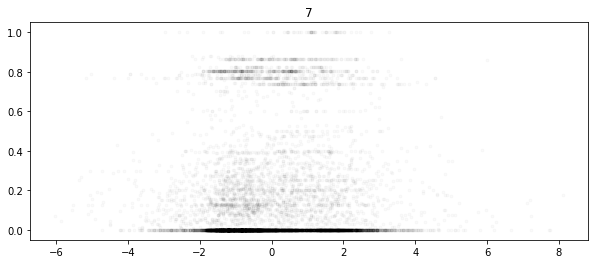

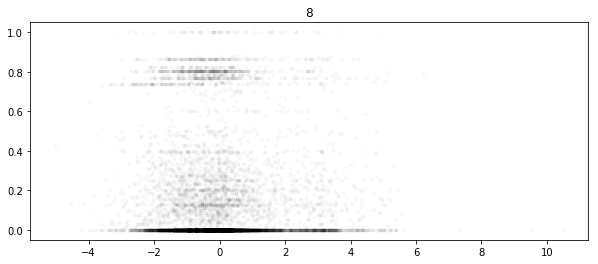

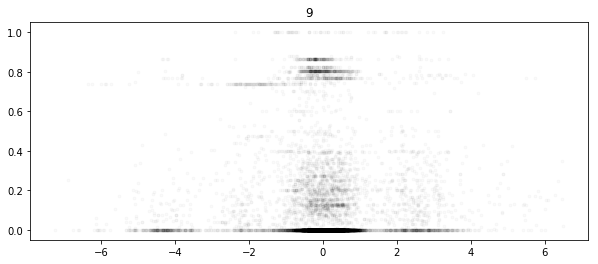

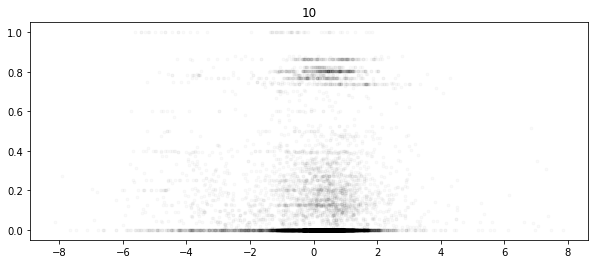

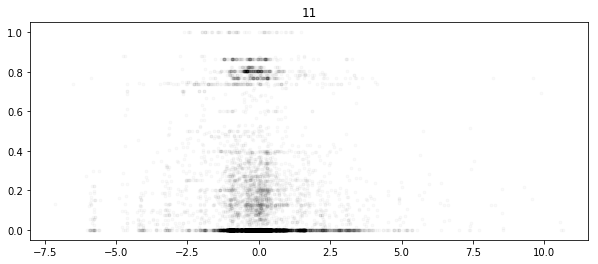

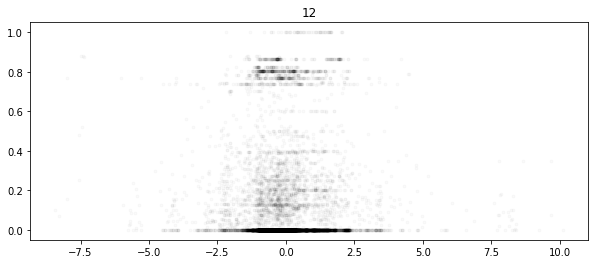

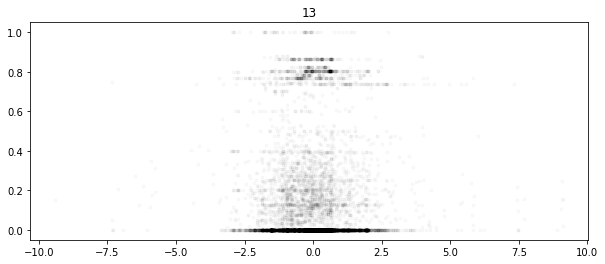

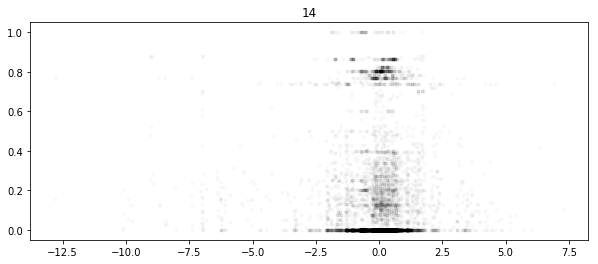

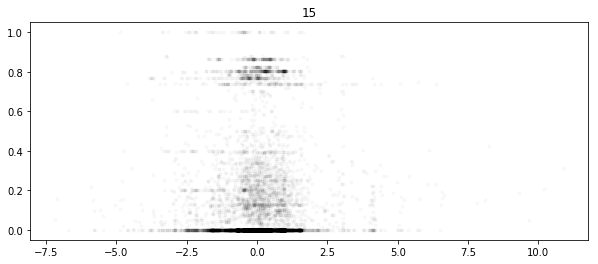

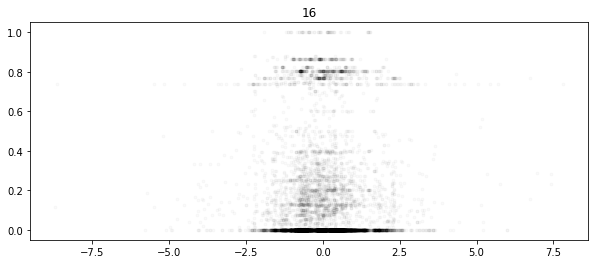

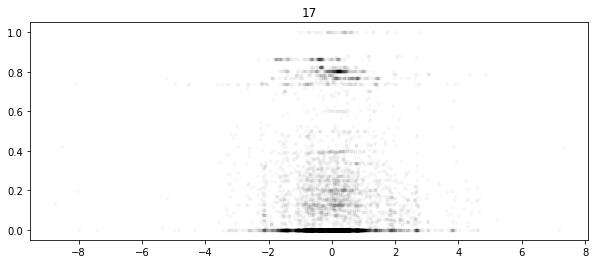

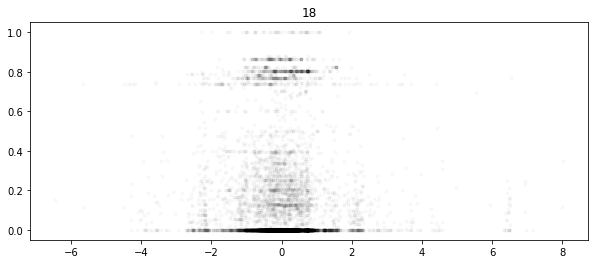

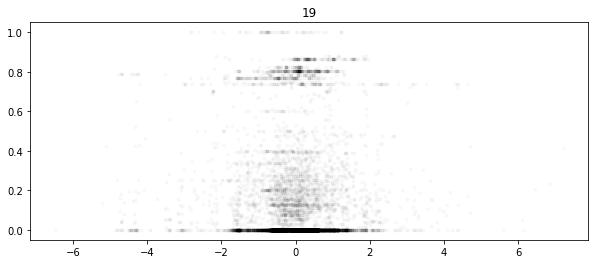

In [30]:
# display results
p = pd.read_csv(f'{data_dir}/train.csv', usecols=['deal_probability'])['deal_probability'].values
inds = np.random.randint(len(p), size=10000)

for j in range(full_svd.shape[1]):
    plt.figure(figsize=(10, 4))
    plt.plot(train_svd[inds,j], p[inds], 'k.', alpha=0.02)
    plt.title(j)
    plt.show()

In [31]:
def save_data(X, f, n_comp=20):
    column_names = [f'price_entity_embed_{i}' for i in range(n_comp)]
    df = pd.DataFrame(X[:,:n_comp], columns=column_names)
    df.to_csv(f, float_format='%0.5f', index=False)
    
save_data(train_svd, f'{feat_dir}/train_price_entity_embed.csv')
save_data(test_svd, f'{feat_dir}/test_price_entity_embed.csv')

In [39]:
pred_train_y = model.predict(train)
pred_test_y = model.predict(test)